In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def half_tone(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    image = 0.3 * r + 0.59 * g + 0.11 * b
    return image

In [ ]:
image = Image.open('/content/drive/MyDrive/University/Computer Vision/references/quant0.png')
image = np.array(image)

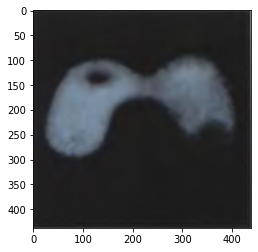

In [ ]:
plt.imshow(image, cmap='gray')

In [ ]:
halftone_image = half_tone(image)

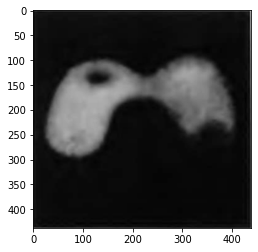

In [ ]:
plt.imshow(halftone_image, cmap='gray')

Quantization

In [ ]:
quant_image = halftone_image.copy()
quant_image = np.array(quant_image, dtype=np.int32)

In [ ]:
width, height = quant_image.shape

In [ ]:
width, height

(438, 439)

In [ ]:
level = 5
max_ = np.max(quant_image)
min_ = np.min(quant_image)

In [ ]:
max_

195

In [ ]:
min_

23

In [ ]:
dist = (max_ - min_) // level

In [ ]:
steps = [min_ + dist*i for i in range(level)]
steps.append(255)
for i in range(len(steps)-1):
    for ii in range(width):
        for jj in range(height):
            if (quant_image[ii][jj] >= steps[i]) and (quant_image[ii][jj] < steps[i+1]):
                quant_image[ii][jj] = i+1

In [ ]:
steps

[23, 57, 91, 125, 159, 255]

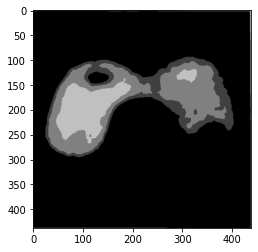

In [ ]:
plt.imshow(quant_image,cmap='gray')

Global Otsu

In [ ]:
k=256

In [ ]:
otsu = Image.open('/content/drive/MyDrive/University/Computer Vision/references/otsu0.png')
width, height = otsu.size
otsu = np.array(otsu)

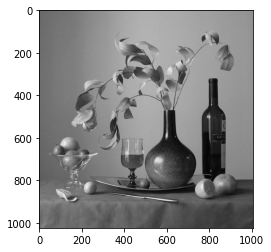

In [ ]:
plt.imshow(hf_otsu, cmap='gray')

In [ ]:
global_otsu_image = otsu.copy()

In [ ]:
def global_otsu(img, width, height):
    image = img.copy()
    image = half_tone(image)
    k = 256
    hist,_ = np.histogram(img.flatten(), bins=256, range=(0,256))
    n = 0
    amountOfPixels = width * height
    histI = 0
    histI1 = 0
    maxDisp = 0
    for i in range(0, k):
        histI += i * hist[i]
    histI = histI / amountOfPixels
    for t in range(0, k):
        n += hist[t]
        omega1 = n / amountOfPixels
        omega2 = 1 - omega1
        if (omega1 != 0) and (omega2 != 0):
            histI1 += t * hist[t]
            mu1 = histI1 / (amountOfPixels * omega1)
            mu2 = (histI - mu1 * omega1) / omega2
            disp = omega1 * omega2 * (mu1 - mu2) ** 2
            if (disp > maxDisp):
                maxDisp = disp
                threshold = t

    for i in range(0, height):
        for j in range(0, width):
            if (image[i][j] > threshold):
                image[i][j] = 255
            else:
                image[i][j] = 0
    return image

In [ ]:
result = global_otsu(global_otsu_image, width, height)

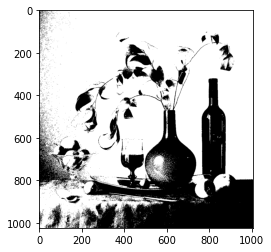

In [ ]:
plt.imshow(result, cmap='gray')

Local Otsu

In [ ]:
otsu_local = Image.open('/content/drive/MyDrive/University/Computer Vision/references/otsu0.png')
width, height = otsu_local.size

In [ ]:
m = 2
n = 2

In [ ]:
def local_otsu(original_image, m, n):
  x = int(width // m)
  y = int(height // n)
  arr = [0, 0]
  arr[0] = [0 for i in range(0, m + 1)]
  arr[1] = [0 for i in range(0, n + 1)]
  for i in range(1, m + 1):
      arr[0][i] = i * x
  for i in range(1, n + 1):
      arr[1][i] = i * y
  k = 0
  part_image = [0 for i in range(0, m * n)]
  new_image = [0 for i in range(0, m)]
  result = [0 for i in range(0, n)]
  for i in range(0, m):
      for j in range(0, n):
          image = np.array(original_image.crop((arr[0][i], arr[1][j], arr[0][i + 1], arr[1][j + 1])))
          part_image[k] = np.array(global_otsu(image, width=arr[0][i + 1] - arr[0][i], height=arr[1][j + 1] - arr[1][j]))
          k += 1

  new_image[0] = np.row_stack(([part_image[0], part_image[1]]))
  new_image[1] = np.row_stack(([part_image[2], part_image[3]]))
  result = np.column_stack([new_image[0], new_image[1]])

  return result

In [ ]:
result_local = local_otsu(otsu_local, m, n)

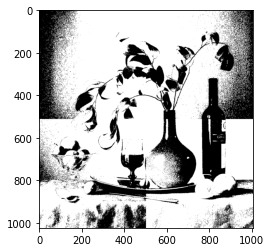

In [ ]:
plt.imshow(result_local, cmap='gray')

Hier Otsu

In [ ]:
level = 2

In [ ]:
hier_image = Image.open('/content/drive/MyDrive/University/Computer Vision/references/otsu0.png')
hier_image = np.array(hier_image)

In [ ]:
def find_thrashold_for_hier_otsu(histogram, low, high):
  k = 0
  NT = 0
  histI = 0
  histI1 = 0
  maxVariance = 0
  threshold = -1
  for i in range(low, high):
        NT += histogram[i]
        histI += i * histogram[i]
  histI = histI / NT
  for t in range(low, high):
      k += histogram[t]
      omega1 = k / NT
      omega2 = 1 - omega1
      if (omega1 != 0) and (omega2 != 0):
          histI1 += t * histogram[t]
          mu1 = histI1 / (NT * omega1)
          mu2 = (histI - mu1 * omega1) / omega2
          variance = omega1 * omega2 * (mu1 - mu2) ** 2
          if (variance > maxVariance):
              maxVariance = variance
              threshold = t
  return threshold

In [ ]:
def recursion_for_hier_otsu(histogram, low, high, threshold, level):
  # Iterations = 2^level - 1
  if level <= 0:
    return
  threshold0 = find_thrashold_for_hier_otsu(histogram, low, high)
  threshold.append(threshold0)
  recursion_for_hier_otsu(histogram, low, threshold0, threshold, level - 1)
  recursion_for_hier_otsu(histogram, threshold0, high, threshold, level - 1)
  return threshold

In [ ]:
def hier_otsu(image, level):
  image = half_tone(image)
  height, width = image.shape[0], image.shape[1]
  k = 256
  thresholds = []
  hist,_ = np.histogram(image.flatten(), bins=256, range=(0,256))
  thresholds = recursion_for_hier_otsu(hist, 0, k, thresholds, level)
  thresholds.sort()
  n = len(thresholds)
  print(thresholds)
  for i in range(height):
    for j in range(width):
      k = 0
      while k < n:
        if image[i][j] < thresholds[k]:
          image[i][j] = thresholds[k]
          k = n
        k += 1
      if image[i][j] > thresholds[n-1]:
        image[i][j] = thresholds[n-1]
  return image

In [ ]:
result_hier = hier_otsu(hier_image, level)

[61, 108, 143]


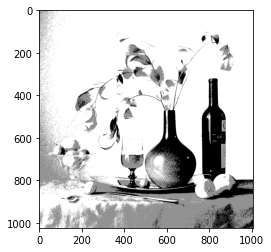

In [ ]:
plt.imshow(result_hier, cmap='gray')